In [1]:
import tensorflow as tf

import os
import time

from matplotlib import pyplot as plt
from IPython import display

In [2]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [3]:
def load(image_file):
    #Reads and outputs the entire contents of the input filename. Return a Tensor of type string.
    image = tf.io.read_file(image_file)
    # Decodificar image. The attr channels indicates the desired number of color channels for the decoded image.
    image = tf.image.decode_jpeg(image)
    # 512 pixel 256*2
    w = tf.shape(image)[1]
    # 512/2 pixel = 256, para partir la foto de la mascara
    w = w // 2
    # separar real imagen desde la imagen de input
    real_image = image[:, :w, :]
    input_image = image[:, w:, :]
    # Casts a tensor to a new type.
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

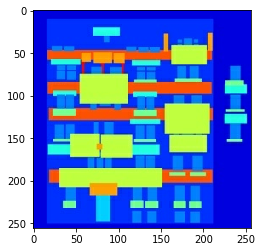

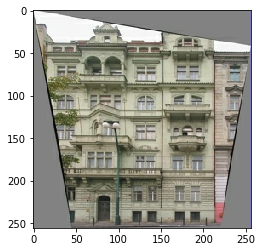

In [4]:
# ejemplo de visualizacíon de las imagenes
inp, re = load('images/facades/train/100.jpg')
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

In [5]:
def resize(input_image, real_image, height, width):
    # resize las dos imagenes con el metodo de los NEAREST_NEIGHBOR
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

In [6]:
def random_crop(input_image, real_image):
    #Stacks a list of rank-R tensors into one rank-(R+1) tensor.
    stacked_image = tf.stack([input_image, real_image], axis=0)
    # Randomly crops a tensor to a given size.
    cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])
    return cropped_image[0], cropped_image[1]

In [7]:
def normalize(input_image, real_image):
    # normalizing the images to [-1, 1]
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

In [8]:
@tf.function()
def random_jitter(input_image, real_image):
    # resizing to 286 x 286 x 3
    input_image, real_image = resize(input_image, real_image, 286, 286)

    # randomly cropping to 256 x 256 x 3
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
    # random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

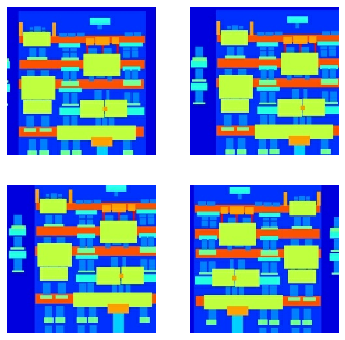

In [9]:
plt.figure(figsize=(6, 6))
for i in range(4):
    rj_inp, rj_re = random_jitter(inp, re)
    plt.subplot(2, 2, i+1)
    plt.imshow(rj_inp/255.0)
    plt.axis('off')
plt.show()

In [10]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [11]:
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [12]:
train_dataset = tf.data.Dataset.list_files('images/facades/train/*.jpg')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [13]:
test_dataset = tf.data.Dataset.list_files('images/facades/train/*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [14]:
train_dataset

<BatchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 3)), types: (tf.float32, tf.float32)>

In [15]:
test_dataset

<BatchDataset shapes: ((None, 256, 256, None), (None, 256, 256, None)), types: (tf.float32, tf.float32)>

In [16]:
#https://machinelearningmastery.com/how-to-develop-a-pix2pix-gan-for-image-to-image-translation/

In [17]:
# https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix accoppiare filtro e foto

# Generador

**Build the Generator <br>
The architecture of generator is a modified U-Net.<br>**
U-Net is a convolutional neural network that was developed for biomedical image segmentation at the Computer Science Department of the University of Freiburg, Germany.[1] The network is based on the fully convolutional network[2] and its architecture was modified and extended to work with fewer training images and to yield more precise segmentations. Segmentation of a 512 × 512 image takes less than a second on a modern GPU.<br>
**Each block in the encoder is (Conv -> Batchnorm -> Leaky ReLU)**<br>
Un'immagine di partenza può essere trasformata ottenendo un particolare effetto applicando ad essa una maschera di convoluzione, cioè una serie di numeri rappresentati spesso da una matrice. Pensate all'operazione di convoluzione come all'applicazione di un filtro su un qualsivoglia programma di computer grafica, dove i filtri stessi sono le maschere di convoluzione. 
e maschere di convoluzione possono essere interpretate come feature detector, cioè come degli strumenti che ci permettono di comprendere i dettagli di un'immagine, come quanto rosso c'è, quante e quali sono le fonti di luce o com'è il rapporto di contrasto. Se prendiamo un'immagine di input e ad essa applichiamo una determinata maschera di convoluzione, potremmo ottenere un'immagine risultate in cui la funzionalità che vogliamo analizzare viene isolata: se vogliamo capire dove sono i punti più scuri in una foto, allora avremmo un'immagine risultante che risulterà di fatto essere un mappa dei toni scuri.<br>
**Batch Normalizacion cosa é?**<br>
velocizzare il training delle reti neurali e migliorarne le performance: i risultati sono incredibili !
L’intuizione da cui nasce la BN è abbastanza semplice: il training delle reti neurali viene rallentano da un fenomeno noto come internal covariate shift.
Ovvero, durante la fase di training, i parametri di ogni sub-strato della rete neurale vengono ottimizzati, affinchè l’errore finale prodotto dalla rete sia minimizzato, iterazione dopo iterazione; ad ogni iterazione, dunque, l’output di ogni sub-strato (che è l’input del sub-strato successivo) varia. Con internal covariate shift ci si riferisce proprio al fatto che ogni strato della rete, ad ogni iterazione, viene esposto ad un input completamente diverso rispetto all’iterazione precedente.
Il cambiamento degli input ad ogni strato rappresenta un problema perchè gli strati della rete devono continuamente adattarsi ad una nuova distribuzione dei valori di ingresso, quindi, per migliorare la fase di training, occorre fissare questa distribuzione.
La soluzione consiste nel normalizzare gli input della rete ad ogni sub-strato della rete stessa (viene chiamata Batch Normalization perchè media e varianza sono calcolati sui valori del batch/gruppo corrente di input).<br>
**ReLU**<br>
Nel contesto delle reti neurali artificiali, il rettificatore è una funzione di attivazione 

**Each block in the decoder is (Transposed Conv -> Batchnorm -> Dropout(applied to the first 3 blocks) -> ReLU)<br>
**Transposed Con** <br>
Quando trasponiamo le convoluzioni, cambiamo l'ordine delle dimensioni in questa matrice di operazioni di convoluzione, che ha alcuni effetti interessanti e porta a comportamenti diversi rispetto alle convoluzioni regolari di cui abbiamo appreso finora.<br>
**dropout**<br>
La tecnica di dropout invece funziona diversamente, in quanto modifica non la funzione di costo della rete, ma la rete stessa. Abbiamo visto il principio di funzionamento di una rete neurale e come essa riesca ad allenarsi. Ecco, questa tecnica prevede di applicare il solito procedimento togliendo prima una certa percentuale di neuroni in ogni hidden layer! Per ogni epoca di allenamento si sceglie (casualmente) quali neuroni tenere e quali scartare e si allena la rete così ottenuta. <br>
**There are skip connections between the encoder and decoder (as in U-Net).**<br>

In [18]:
OUTPUT_CHANNELS = 3

In [20]:
def downsample(filters, size, apply_batchnorm=True):
    #Initializer that generates tensors with a normal distribution.
    initializer = tf.random_normal_initializer(0., 0.02)
    # Sequential groups a linear stack of layers into a tf.keras.Model.
    result = tf.keras.Sequential()
    # añado una capa de convolucíon 2D convolution layer (e.g. spatial convolution over images).
    # params filters:Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).
    # size? existe kernel_size
    # 	An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window. 
    # Can be a single integer to specify the same value for all spatial dimensions.
    # strides: i passi della convoluzione lungo l'altezza e la larghezza. 
    # padding: one of "valid" or "same" (case-insensitive).
    # kernel_initializer: Initializer for the kernel weights matrix ( see keras.initializers).
    # use_bias = Boolean, whether the layer uses a bias vector.
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        # BatchNormalization = Normalize and scale inputs or activations. 
        result.add(tf.keras.layers.BatchNormalization())
        # LeakyReLU = Leaky version of a Rectified Linear Unit.
        result.add(tf.keras.layers.LeakyReLU())

    return result